File not found: C:\Users\danap\OCHRE_Working\180110_1_3_Efficiencyv3_Level2_Control.parquet
File not found: C:\Users\danap\OCHRE_Working\180110_1_3_Efficiencyv3_Level3_Control.parquet
File not found: C:\Users\danap\OCHRE_Working\180110_1_3_Efficiencyv3_Level4_Control.parquet
File not found: C:\Users\danap\OCHRE_Working\180110_1_3_Efficiencyv3_Level5_Control.parquet
File not found: C:\Users\danap\OCHRE_Working\180110_1_3_Efficiencyv3_Level6_Control.parquet


C:\Users\danap\AppData\Local\Temp\ipykernel_25124\3708864451.py:140: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_ctrl.legend(fontsize=8, ncol=2, bbox_to_anchor=(1.01, 1))
C:\Users\danap\AppData\Local\Temp\ipykernel_25124\3708864451.py:146: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_power.legend(fontsize=8, ncol=2, bbox_to_anchor=(1.01, 1))


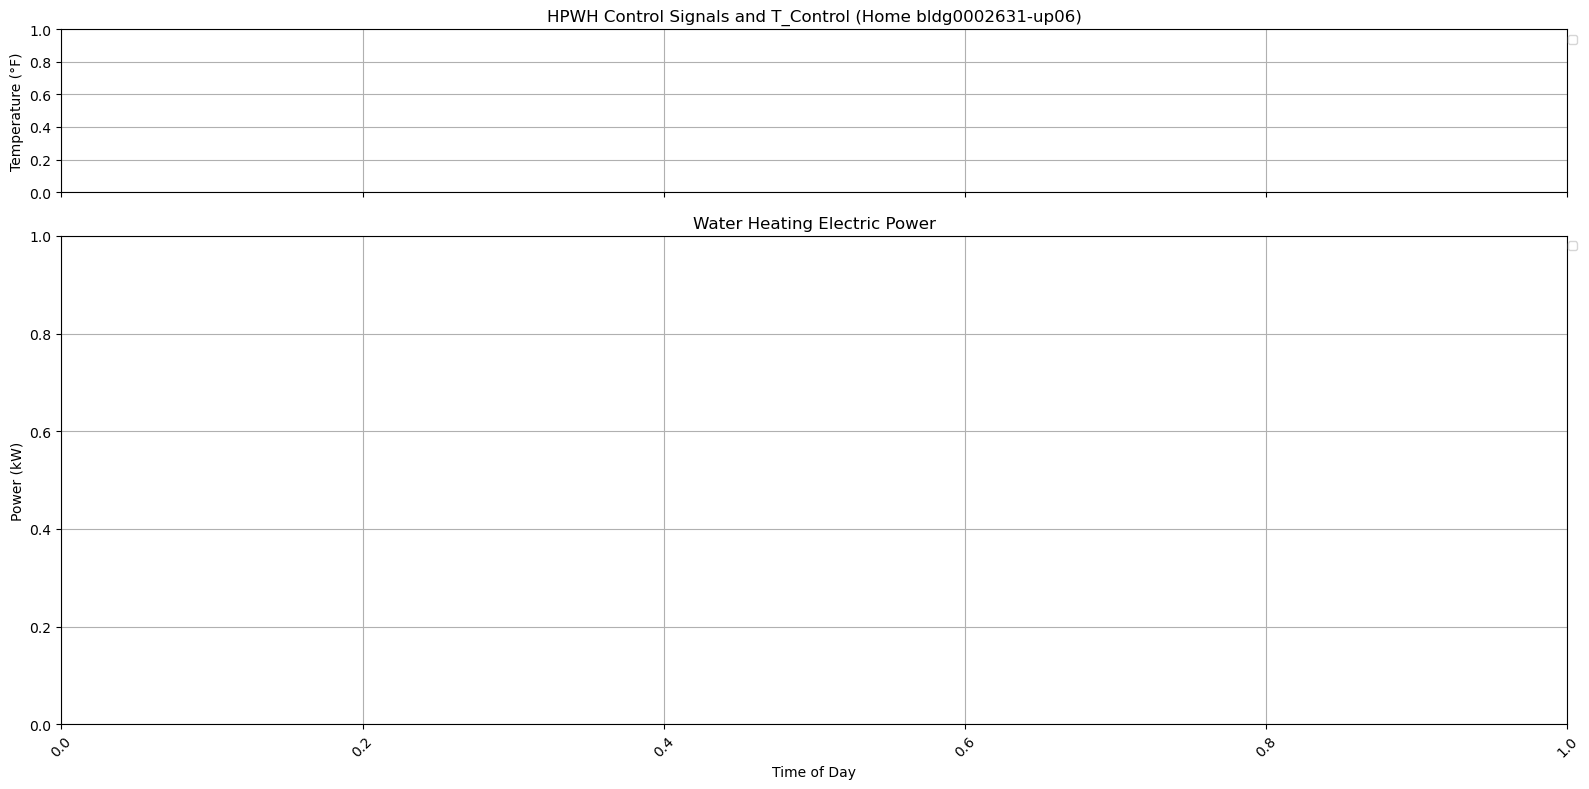

In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# -------------------------------
# USER SETTINGS
# -------------------------------
WORKING_DIR = r"C:\Users\danap\OCHRE_Working"

LEVEL_START = 2      # minimum level to plot
LEVEL_END   = 6      # maximum level to plot
HOME_ID     = 'bldg0002631-up06'      # <<< HOME TO PLOT

# Columns
Ttrue_col    = "Water Heating Control Temperature (C)"
power_col    = "Water Heating Electric Power (kW)"
control_cols = ["ER_ON", "ER_OFF", "HP_ON", "HP_OFF"]

# -------------------------------
# FUNCTIONS
# -------------------------------
def c_to_f(temp_c):
    """Convert Celsius to Fahrenheit"""
    return temp_c * 9/5 + 32

def process_dataset(path):
    df = pd.read_parquet(path)

    if "Time" in df.columns:
        df["Time"] = pd.to_datetime(df["Time"])
        df.set_index("Time", inplace=True)

    df["time_of_day"] = df.index.time
    return df

def time_of_day_to_datetime(idx):
    ref_date = datetime(2000, 1, 1)
    return [
        ref_date.replace(hour=t.hour, minute=t.minute, second=0)
        for t in idx
    ]

# -------------------------------
# INITIALIZE FIGURE
# -------------------------------
fig, (ax_ctrl, ax_power) = plt.subplots(
    2, 1,
    figsize=(16, 8),
    sharex=True,
    gridspec_kw={"height_ratios": [1, 3]}
)

# -------------------------------
# LOOP OVER LEVELS
# -------------------------------
for level in range(LEVEL_START, LEVEL_END + 1):

    filename = f"180110_1_3_Efficiencyv3_Level{level}_Control.parquet"
    CONTROLLED_FILE = os.path.join(WORKING_DIR, filename)

    if not os.path.exists(CONTROLLED_FILE):
        print(f"File not found: {CONTROLLED_FILE}")
        continue

    print(f"Processing Level {level}")

    df = process_dataset(CONTROLLED_FILE)

    # -------------------------------
    # FILTER TO ONE HOME
    # -------------------------------
    df_home = df[df["Home"] == HOME_ID]

    if df_home.empty:
        print(f"No data for Home {HOME_ID} at Level {level}")
        continue

    # -------------------------------
    # COMPOSITE DAILY PROFILE
    # -------------------------------
    composite = {}

    composite["Power_Controlled"] = (
        df_home.groupby("time_of_day")[power_col].mean()
    )

    composite[Ttrue_col] = c_to_f(
        df_home.groupby("time_of_day")[Ttrue_col].mean()
    )

    for c in control_cols:
        composite[c] = c_to_f(
            df_home.groupby("time_of_day")[c].mean()
        )

    time_index = time_of_day_to_datetime(
        composite["Power_Controlled"].index
    )

    # -------------------------------
    # PLOTTING
    # -------------------------------

    # Control signals + control temperature
    ax_ctrl.plot(
        time_index, composite["ER_ON"],
        linestyle="-", label=f"ER_ON L{level}"
    )
    ax_ctrl.plot(
        time_index, composite["ER_OFF"],
        linestyle="--", label=f"ER_OFF L{level}"
    )
    ax_ctrl.plot(
        time_index, composite["HP_ON"],
        linestyle=":", label=f"HP_ON L{level}"
    )
    ax_ctrl.plot(
        time_index, composite["HP_OFF"],
        linestyle="-.", label=f"HP_OFF L{level}"
    )

    ax_ctrl.plot(
        time_index, composite[Ttrue_col],
        linewidth=3, label=f"T_Control L{level}"
    )

    # Power
    ax_power.plot(
        time_index, composite["Power_Controlled"],
        linewidth=2, label=f"Power L{level}"
    )

# -------------------------------
# FINALIZE PLOT
# -------------------------------
ax_ctrl.set_ylabel("Temperature (°F)")
ax_ctrl.set_title(f"HPWH Control Signals and T_Control (Home {HOME_ID})")
ax_ctrl.grid(True)
ax_ctrl.legend(fontsize=8, ncol=2, bbox_to_anchor=(1.01, 1))

ax_power.set_ylabel("Power (kW)")
ax_power.set_xlabel("Time of Day")
ax_power.set_title("Water Heating Electric Power")
ax_power.grid(True)
ax_power.legend(fontsize=8, ncol=2, bbox_to_anchor=(1.01, 1))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Processing Level 2
Processing Level 3


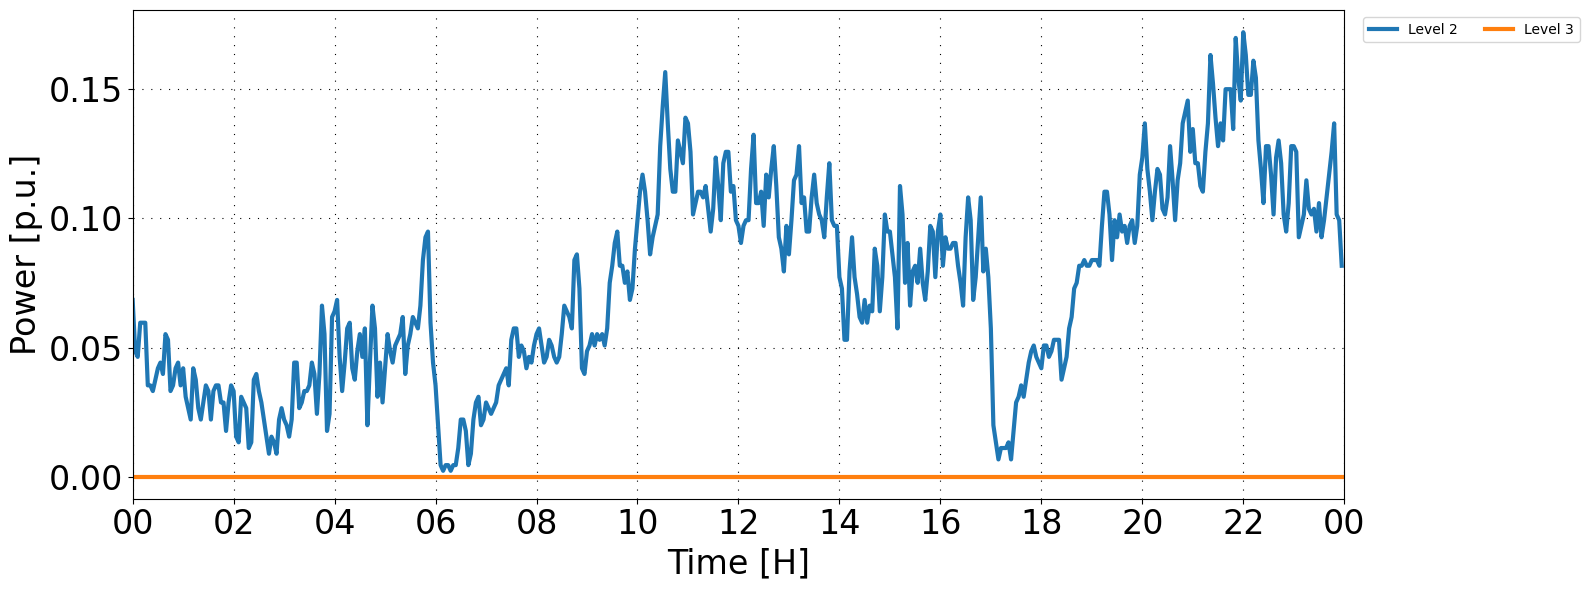

In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.ticker import StrMethodFormatter
from datetime import timedelta


# -------------------------------
# USER SETTINGS
# -------------------------------
WORKING_DIR = r"C:\Users\danap\OCHRE_Working"
LEVEL_START = 2  # minimum level to plot
LEVEL_END = 3    # maximum level to plot

# Columns
Ttrue_col   = "Water Heating Control Temperature (C)"
power_col   = "Water Heating Electric Power (kW)"
control_cols = ["ER_ON", "ER_OFF", "HP_ON", "HP_OFF"]

# Parameters
Prated = 5
N_homes = 409
days = 1
N = N_homes * Prated * days  # normalization factor

A = 24
ref_date = datetime(2000, 1, 1)

# -------------------------------
# FUNCTIONS
# -------------------------------
def c_to_f(temp_c):
    """Convert Celsius to Fahrenheit"""
    return temp_c * 9/5 + 32

def process_dataset(path):
    df_raw = pd.read_parquet(path)
    if 'Time' in df_raw.columns:
        df_raw['Time'] = pd.to_datetime(df_raw['Time'])
        df_raw.set_index('Time', inplace=True)
    df_raw["time_of_day"] = df_raw.index.time
    return df_raw

def time_of_day_to_datetime(idx):
    ref_date = datetime(2000,1,1)
    return [ref_date.replace(hour=t.hour, minute=t.minute, second=0) for t in idx]

# -------------------------------
# INITIALIZE FIGURE
# -------------------------------
fig, ax_power = plt.subplots(1, 1, figsize=(16, 6))


# Use gnuplot2 colormap
n_levels = LEVEL_END - LEVEL_START + 1
# colors = ['red', 'blue', 'orange', 'green', 'yellow', 'purple', 'black', 'lightblue']

# -------------------------------
# LOOP OVER LEVELS
# -------------------------------
for i, level in enumerate(range(LEVEL_START, LEVEL_END + 1)):
    filename = f"180110_1_3_Efficiencyv5_Level{level}_Control.parquet"
    CONTROLLED_FILE = os.path.join(WORKING_DIR, filename)

    if not os.path.exists(CONTROLLED_FILE):
        print(f"File not found: {CONTROLLED_FILE}, skipping Level {level}")
        continue

    print(f"Processing Level {level}")
    df_controlled = process_dataset(CONTROLLED_FILE)

    composite = {}
    composite['Power_Controlled'] = (
        df_controlled.groupby("time_of_day")[power_col].sum() / N
    )

    time_index = time_of_day_to_datetime(
        composite['Power_Controlled'].index
    )

    ax_power.plot(
        time_index,
        composite['Power_Controlled'],
        label=f"Level {level}",
        linewidth=3
    )

# -------------------------------
# FINALIZE PLOT – MATCH STYLE
# -------------------------------


# --- Power axis (bottom) ---
ax_power.set_ylabel("Power [p.u.]", fontsize=A, color='black')
ax_power.set_xlabel("Time [H]", fontsize=A, color='black')

ax_power.tick_params(axis='y', labelcolor='black', labelsize=A)
ax_power.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))

ax_power.grid(True, linestyle=(0, (1, 7)), linewidth=0.8, color='black')

ax_power.legend(fontsize=10, ncol=2, bbox_to_anchor=(1.01, 1))


# -------------------------------
# X-axis formatting (shared)
# -------------------------------
ax_power.set_ylabel("Power [p.u.]", fontsize=A, color='black')
ax_power.set_xlabel("Time [H]", fontsize=A, color='black')

ax_power.tick_params(axis='y', labelcolor='black', labelsize=A)
ax_power.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))

ax_power.tick_params(axis='x', labelrotation=0, labelsize=A)

# X-axis time formatting
ax_power.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax_power.xaxis.set_major_locator(mdates.HourLocator(interval=2))

# Midnight → midnight
ax_power.set_xlim(ref_date, ref_date + timedelta(days=1))

# Grid style
ax_power.grid(True, linestyle=(0, (1, 7)), linewidth=0.8, color='black')

# Legend
ax_power.legend(fontsize=10, ncol=2, bbox_to_anchor=(1.01, 1))

plt.tight_layout()
plt.show()


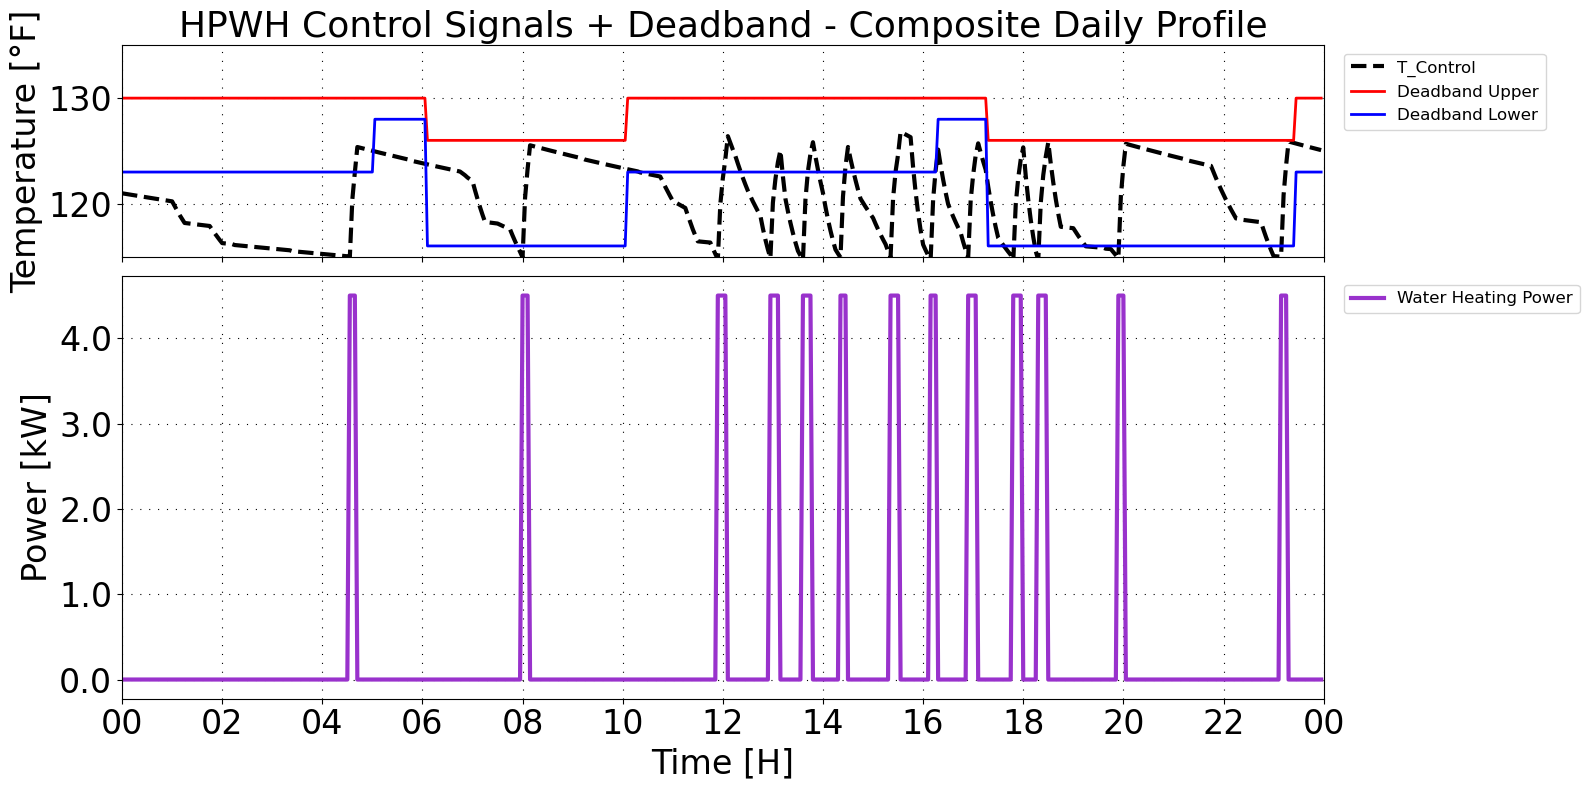

In [107]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import StrMethodFormatter
from datetime import datetime, timedelta

# -------------------------------
# USER SETTINGS
# -------------------------------
FILE_PATH = r"C:\Users\danap\OCHRE_Working\Input Files\bldg0002631-up06\Results\hpwh_controlled.parquet"
Ttrue_col   = "Water Heating Control Temperature (C)",
upper_deadband_col = "Water Heating Deadband Upper Limit (C)"
lower_deadband_col = "Water Heating Deadband Lower Limit (C)"
power_col   = "Water Heating Electric Power (kW)"
A = 24  # Font size for axes

# -------------------------------
# FUNCTIONS
# -------------------------------
def process_dataset(path):
    df = pd.read_parquet(path)
    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time', inplace=True)
    df['time_of_day'] = df.index.time
    return df

def time_of_day_to_datetime(idx):
    ref_date = datetime(2000,1,1)
    return [ref_date.replace(hour=t.hour, minute=t.minute, second=0) for t in idx]

def c2f(Tc):
    return 9/5 * Tc + 32

# -------------------------------
# LOAD DATA
# -------------------------------
if not os.path.exists(FILE_PATH):
    raise FileNotFoundError(f"{FILE_PATH} does not exist!")

df_house = process_dataset(FILE_PATH)

# -------------------------------
# COLLAPSE TO COMPOSITE BY TIME OF DAY
# -------------------------------
composite = {}
columns_to_process = [Ttrue_col, upper_deadband_col, lower_deadband_col, power_col]
for col in columns_to_process:
    composite[col] = df_house.groupby('time_of_day')[col].mean()

time_index = time_of_day_to_datetime(composite[Ttrue_col].index)

# -------------------------------
# PLOTTING
# -------------------------------
fig, (ax_ctrl, ax_power) = plt.subplots(2,1, figsize=(16,8), sharex=True,
                                        gridspec_kw={'height_ratios':[1,2]})

# --- Control signals + Deadband ---
ax_ctrl.plot(time_index, c2f(composite[Ttrue_col]), label="T_Control", color='black', linewidth=3, linestyle='--')
ax_ctrl.plot(time_index, c2f(composite[upper_deadband_col]), label="Deadband Upper", color='red', linestyle='-', linewidth=2)
ax_ctrl.plot(time_index, c2f(composite[lower_deadband_col]), label="Deadband Lower", color='blue', linestyle='-', linewidth=2)

ax_ctrl.set_ylabel("Temperature [°F]", fontsize=A)
ax_ctrl.tick_params(axis='y', labelsize=A)
ax_ctrl.grid(True, linestyle=(0, (1,7)), linewidth=0.8, color='black')
ax_ctrl.legend(fontsize=12, ncol=1, bbox_to_anchor=(1.01, 1))
ax_ctrl.set_title("HPWH Control Signals + Deadband - Composite Daily Profile", fontsize=A+2)

# --- Power signals ---
ax_power.plot(time_index, composite[power_col], label="Water Heating Power", color='darkorchid', linewidth=3)
ax_power.set_ylabel("Power [kW]", fontsize=A)
ax_power.set_xlabel("Time [H]", fontsize=A)
ax_power.tick_params(axis='y', labelsize=A)
ax_power.tick_params(axis='x', labelsize=A)
ax_power.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))

ax_ctrl.set_ylim(115, 135)

# X-axis time formatting
ax_power.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax_power.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ref_date = datetime(2000,1,1)
ax_power.set_xlim(ref_date, ref_date + timedelta(days=1))

ax_power.grid(True, linestyle=(0,(1,7)), linewidth=0.8, color='black')
ax_power.legend(fontsize=12, ncol=1, bbox_to_anchor=(1.01, 1))

plt.tight_layout()
plt.show()
